In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
file_path = '/content/drive/MyDrive/Solar energy prediction - Project/Datasets/Out/full.csv'

In [17]:
df = pd.read_csv(file_path, parse_dates= True, index_col= 0)
df.head()

,Solaire (MW),air_temp,precip_depth_per_hour,station_pressure_rate,Vitesse du vent à 100m (m/s),Rayonnement solaire global (W/m2)
2017-01-01 01:00:00,0,-37.0,0.0,10180.0,4.53,0.00
2017-01-01 04:00:00,0,-40.0,0.0,10162.0,5.30,0.00
2017-01-01 07:00:00,0,-41.0,0.0,10144.0,4.92,0.00
2017-01-01 10:00:00,15,-30.0,0.0,10137.0,4.71,7.09
2017-01-01 13:00:00,22,-10.0,0.0,10115.0,4.30,84.24


In [18]:
cols_to_transform = ['air_temp', 'precip_depth_per_hour', 'station_pressure_rate', 'Vitesse du vent à 100m (m/s)', 'Rayonnement solaire global (W/m2)']

In [19]:
#Delete unnecessary columns, then convert the "Date" column to time data type, and set the "Date" column as an index
df.drop(df[cols_to_transform], axis=1, inplace=True)
df.index = pd.to_datetime(df.index)
df = df.set_index(df.index, drop=True)
print(df.head(10))

                     Solaire (MW)
2017-01-01 01:00:00             0
2017-01-01 04:00:00             0
2017-01-01 07:00:00             0
2017-01-01 10:00:00            15
2017-01-01 13:00:00            22
2017-01-01 16:00:00             1
2017-01-01 19:00:00             0
2017-01-01 22:00:00             0
2017-01-02 01:00:00             0
2017-01-02 04:00:00             0


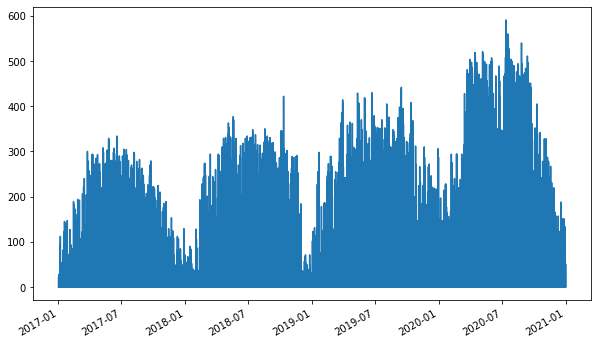

In [20]:
#Draw a time series line graph
plt.figure(figsize=(10, 6))
df['Solaire (MW)'].plot()
plt.show()

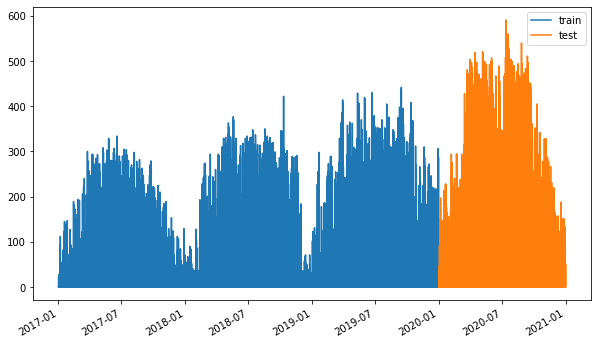

In [21]:
#Split the data into training set and test set by date "2018–01–01", that is, the data before this date is the training data, and the data after this date is the test data. We will visualize it again.
split_date = pd.Timestamp('2020-01-01')
df = df['Solaire (MW)']
train = df.loc[:split_date]
test = df.loc[split_date:]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])
plt.show()

## **Simple artificial neural network for time series forecasting**

The activation function is the linear rectification function Relu (Rectified Linear Unit, also known as the corrected linear unit).

The loss function is mean_squared_error, and the optimizer is Adam.

When it is detected that the loss stops improving, the training ends.

Patience = 2, which means that the result has not improved after several cycles, and the training can be ended at this time.

The training time of the artificial neural network is 100 cycles, and each time 96 samples are used for training.

In [49]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train = np.array(train).reshape(-1,1)
test = np.array(test).reshape(-1,1)
train_sc = scaler.fit_transform(train)

#Get training and test data, here is a period of lag
X_train = train_sc[:-1]
y_train = train_sc[1:]
X_test = test_sc[:-1]
y_test = test_sc[1:]

In [73]:
nn_model = Sequential()
nn_model.add(Dense(100, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=96, verbose=2, callbacks=[early_stop], shuffle=False)

Epoch 1/100
92/92 - 1s - loss: 0.2072
Epoch 2/100
92/92 - 0s - loss: 0.1041
Epoch 3/100
92/92 - 0s - loss: 0.1040
Epoch 4/100
92/92 - 0s - loss: 0.1039
Epoch 5/100
92/92 - 0s - loss: 0.1038
Epoch 6/100
92/92 - 0s - loss: 0.1037
Epoch 7/100
92/92 - 0s - loss: 0.1035
Epoch 8/100
92/92 - 0s - loss: 0.1035
Epoch 9/100
92/92 - 0s - loss: 0.1035
Epoch 10/100
92/92 - 0s - loss: 0.1035
Epoch 11/100
92/92 - 0s - loss: 0.1034
Epoch 12/100
92/92 - 0s - loss: 0.1034
Epoch 13/100
92/92 - 0s - loss: 0.1034
Epoch 14/100
92/92 - 0s - loss: 0.1034
Epoch 15/100
92/92 - 0s - loss: 0.1034
Epoch 16/100
92/92 - 0s - loss: 0.1034
Epoch 17/100
92/92 - 0s - loss: 0.1033
Epoch 18/100
92/92 - 0s - loss: 0.1033
Epoch 19/100
92/92 - 0s - loss: 0.1033
Epoch 20/100
92/92 - 0s - loss: 0.1033
Epoch 21/100
92/92 - 0s - loss: 0.1033
Epoch 22/100
92/92 - 0s - loss: 0.1032
Epoch 23/100
92/92 - 0s - loss: 0.1032
Epoch 24/100
92/92 - 0s - loss: 0.1032
Epoch 25/100
92/92 - 0s - loss: 0.1032
Epoch 26/100
92/92 - 0s - loss: 0.

In [74]:
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

The R2 score on the Train set is:	0.422
The R2 score on the Test set is:	0.440


## **LSTM**

The construction and model compilation of LSTM networks are similar to artificial neural networks.

LSTM has a visible layer, which has 1 input.

The hidden layer has 96 LSTM neurons.

The output layer performs single-value prediction.

LSTM neurons are activated using the Relu function.

The training time of LSTM is 100 cycles, and each time 96 sample is used for training.

In [75]:
X_train_lmse = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_lmse = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

lstm_model = Sequential()
lstm_model.add(LSTM(100, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=100, batch_size=96, verbose=2, shuffle=False, callbacks=[early_stop])

Epoch 1/100
92/92 - 2s - loss: 0.3813
Epoch 2/100
92/92 - 0s - loss: 0.1054
Epoch 3/100
92/92 - 0s - loss: 0.1035
Epoch 4/100
92/92 - 0s - loss: 0.1032
Epoch 5/100
92/92 - 0s - loss: 0.1030
Epoch 6/100
92/92 - 0s - loss: 0.1028
Epoch 7/100
92/92 - 0s - loss: 0.1026
Epoch 8/100
92/92 - 0s - loss: 0.1025
Epoch 9/100
92/92 - 0s - loss: 0.1024
Epoch 10/100
92/92 - 0s - loss: 0.1023
Epoch 11/100
92/92 - 0s - loss: 0.1022
Epoch 12/100
92/92 - 0s - loss: 0.1021
Epoch 13/100
92/92 - 0s - loss: 0.1020
Epoch 14/100
92/92 - 0s - loss: 0.1020
Epoch 15/100
92/92 - 0s - loss: 0.1020
Epoch 16/100
92/92 - 0s - loss: 0.1019
Epoch 17/100
92/92 - 0s - loss: 0.1019
Epoch 18/100
92/92 - 0s - loss: 0.1019
Epoch 19/100
92/92 - 0s - loss: 0.1019
Epoch 20/100
92/92 - 0s - loss: 0.1019
Epoch 21/100
92/92 - 0s - loss: 0.1019
Epoch 22/100
92/92 - 0s - loss: 0.1019
Epoch 23/100
92/92 - 0s - loss: 0.1019
Epoch 00023: early stopping


In [76]:
y_pred_test_lstm = lstm_model.predict(X_test_lmse)
y_train_pred_lstm = lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

The R2 score on the Train set is:	0.423
The R2 score on the Test set is:	0.439


## **Compare models**

We compared the test MSE of the two models

In [77]:
nn_test_mse = nn_model.evaluate(X_test, y_test, batch_size=96)
lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=96)
print('NN: %f'%nn_test_mse)
print('LSTM: %f'%lstm_test_mse)

31/31 [==============================] - 1s 2ms/step - loss: 0.2209
NN: 0.220525
LSTM: 0.220944


## **Make predictions**

In [78]:
#Make predictions
nn_y_pred_test = nn_model.predict(X_test)
lstm_y_pred_test = lstm_model.predict(X_test_lmse)

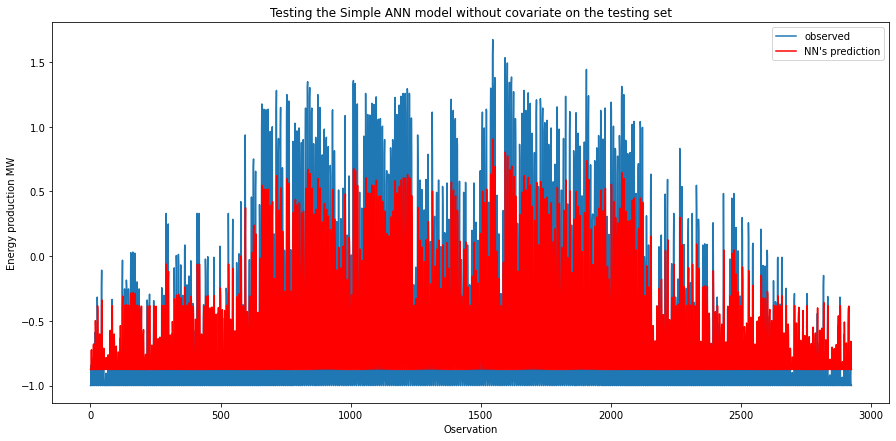

In [84]:
plt.figure(figsize = (15,7))
_ = plt.plot(y_test, label='observed')

# plot your mean predictions
_ = plt.plot(y_pred_test_nn, 'r', label='NN\'s prediction')

# set labels, legends and show plot
_ = plt.xlabel('Oservation')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing the Simple ANN model without covariate on the testing set')

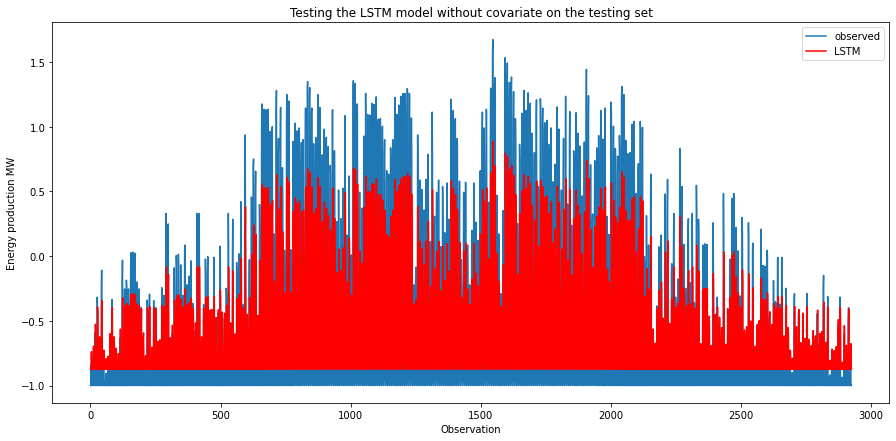

In [85]:
plt.figure(figsize = (15,7))
_ = plt.plot(y_test, label='observed')

# plot your mean predictions
_ = plt.plot(y_pred_test_lstm, 'r', label='LSTM')

# set labels, legends and show plot
_ = plt.xlabel('Observation')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing the LSTM model without covariate on the testing set')

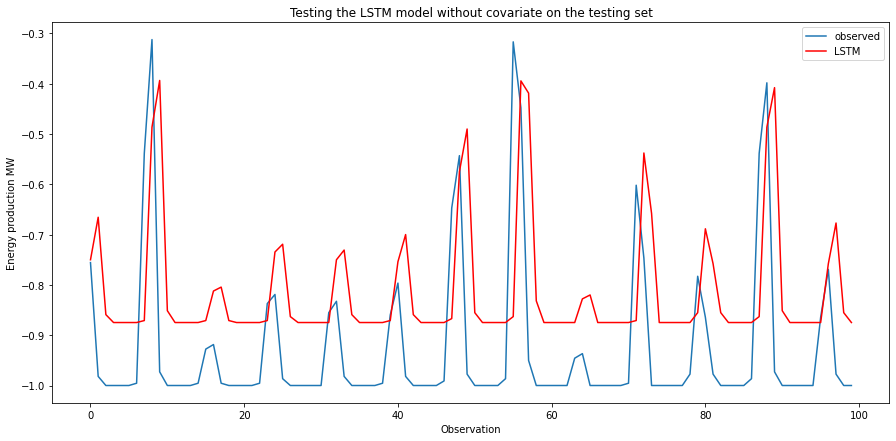

In [87]:
plt.figure(figsize = (15,7))
_ = plt.plot(y_test[-100:], label='observed')

# plot your mean predictions
_ = plt.plot(y_pred_test_lstm[-100:], 'r', label='LSTM')

# set labels, legends and show plot
_ = plt.xlabel('Observation')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing the LSTM model without covariate on the testing set')